# Setup

## Connect Google Drive Folder

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
cwk_dir ="drive/MyDrive/NLU Coursework/"

data_dir = os.path.join(cwk_dir, "data")

solution_dir = os.path.join(cwk_dir, "solution B")
models_dir = os.path.join(solution_dir, "models")
results_dir = os.path.join(solution_dir, "results")

Mounted at /content/drive/


## Imports

In [2]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import typing
from PIL import Image

## Primary Variables

Filepath variables

In [4]:
TRAIN_FILEPATH: str = os.path.join(data_dir, "training_data/training_data/NLI")
TRAIN_DATASET: str = os.path.join(TRAIN_FILEPATH, "train.csv")
DEV_DATASET: str = os.path.join(TRAIN_FILEPATH, "dev.csv")

TRIAL_FILEPATH: str = os.path.join(data_dir, "trial_data/trial_data")
TRIAL_DATASET: str = os.path.join(TRIAL_FILEPATH, "NLI_trial.csv")

Label variables

In [5]:
PREMISE_KEY: str = "premise"
HYPOTHESIS_KEY: str = "hypothesis"
LABEL_KEY: str = "label"

Preprocessing variables

In [6]:
LOWER: bool = True
PADDING: str = "post"

Training variables

In [7]:
INITIAL_LR: float = 1e-3
EPOCHS: int = 20
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 32

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [8]:
MAX_SEQ_LENGTH: int = -1
VOCAB_SIZE: int = -1
EMBEDDING_SIZE: int = 100

## Functions

In [9]:
def load_data_csv(filepath: str) -> typing.Tuple[typing.List[str], typing.List[str], typing.List[int]]:
  """
  Will load in data from the filepath specified. Expects the string filepath to a csv file. Returns tuple of the premises, hypotheses and labels
  """
  dataset = pd.read_csv(filepath).to_dict()
  premises = list(map(str, dataset[PREMISE_KEY].values()))
  hypotheses = list(map(str, dataset[HYPOTHESIS_KEY].values()))
  labels = list(map(int, dataset[LABEL_KEY].values()))
  return (premises, hypotheses,labels)

In [10]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [11]:
def tokenize_data(tokenizer: Tokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly
  """
  premises = tokenizer.texts_to_sequences(premises)
  hypotheses = tokenizer.texts_to_sequences(hypotheses)

  premises = pad_sequences(premises, maxlen=MAX_SEQ_LENGTH, padding=PADDING)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_SEQ_LENGTH, padding=PADDING)

  return (np.array(premises), np.array(hypotheses))

# Data Preprocessing

## Load Data

In [12]:
train_premises, train_hypotheses, train_labels = load_data_csv(filepath=TRAIN_DATASET)
dev_premises, dev_hypotheses, dev_labels = load_data_csv(filepath=DEV_DATASET)

In [13]:
train_labels = np.array(train_labels).reshape(len(train_labels),1)
dev_labels = np.array(dev_labels).reshape(len(dev_labels),1)

In [14]:
MAX_SEQ_LENGTH = max(max([len(sample) for sample in train_hypotheses]), max([len(sample) for sample in train_premises]), max([len(sample) for sample in dev_premises]), max([len(sample) for sample in dev_hypotheses]))
print(f"Max sequence length: {MAX_SEQ_LENGTH}")

Max sequence length: 1362


## Tokenize Data

In [15]:
tokenizer = Tokenizer(lower=LOWER)
tokenizer.fit_on_texts(train_premises + train_hypotheses + dev_premises + dev_hypotheses)

In [16]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=train_premises, hypotheses=train_hypotheses)
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=dev_premises, hypotheses=dev_hypotheses)

In [17]:
VOCAB_SIZE = num_words = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 40421


## Split Data

In [18]:
#Nothing for now

# Model Training

## Model Architecture

In [19]:
input_premises = Input(shape=(MAX_SEQ_LENGTH,))
input_hypotheses = Input(shape=(MAX_SEQ_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE)

premises_embedding = embedding_layer(input_premises)
hypotheses_embedding = embedding_layer(input_hypotheses)

bi_lstm_premises = Bidirectional(LSTM(64, return_sequences=True))(premises_embedding)
bi_lstm_hypotheses = Bidirectional(LSTM(64, return_sequences=True))(hypotheses_embedding)

merged = concatenate([bi_lstm_premises, bi_lstm_hypotheses], axis=-1)

dense_layer = Dense(64, activation='relu')(merged)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

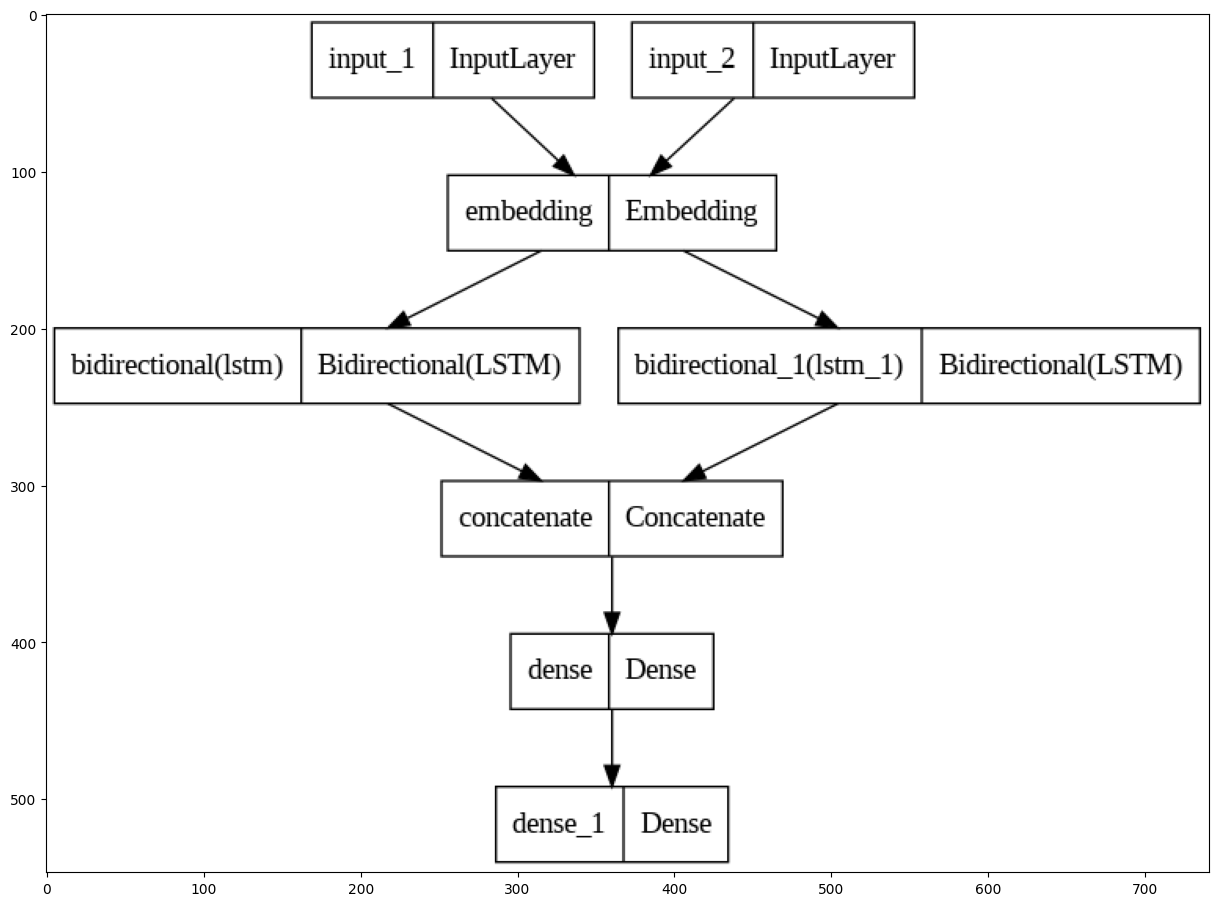

In [20]:
show_model_architecture(model=model, filename="model_architecture.png")

## Model Training

In [21]:
model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/20
674/674 [==============================] - 121s 165ms/step - loss: 0.6828 - accuracy: 0.5530 - val_loss: 0.6632 - val_accuracy: 0.6030
Epoch 2/20
674/674 [==============================] - 108s 159ms/step - loss: 0.6328 - accuracy: 0.6658 - val_loss: 0.6385 - val_accuracy: 0.6685
Epoch 3/20
674/674 [==============================] - 108s 160ms/step - loss: 0.5956 - accuracy: 0.7132 - val_loss: 0.6388 - val_accuracy: 0.6748
Epoch 4/20
674/674 [==============================] - 108s 160ms/step - loss: 0.5551 - accuracy: 0.7460 - val_loss: 0.6747 - val_accuracy: 0.6575
Epoch 5/20
674/674 [==============================] - 107s 159ms/step - loss: 0.5185 - accuracy: 0.7607 - val_loss: 0.6730 - val_accuracy: 0.6524
Epoch 6/20
674/674 [==============================] - 107s 159ms/step - loss: 0.4877 - accuracy: 0.7796 - val_loss: 0.7095 - val_accuracy: 0.6673
Epoch 7/20
674/674 [==============================] - 108s 160ms/step - loss: 0.4506 - accuracy: 0.8028 - val_loss: 0.7763 -

KeyboardInterrupt: 

## Model Evaluation

In [22]:
loss, accuracy = model.evaluate([dev_premises, dev_hypotheses], dev_labels)
print("\nTest score/loss:", loss)
print('Test accuracy:', accuracy)

211/211 [==============================] - 14s 65ms/step - loss: 0.7936 - accuracy: 0.6470

Test score/loss: 0.7936230301856995
Test accuracy: 0.6470398306846619
